<center><img src="https://github.com/DACSS-Spatial/data_forSpatial/raw/main/logo.png" width="700"></center>

<a target="_blank" href="https://colab.research.google.com/github/DACSS-Spatial/The-Thematics/blob/main/index.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# The Thematic map

Last session we created a file with several layers:

In [12]:
import geopandas as gpd

linkGit='https://raw.githubusercontent.com/meade68/DACSS_690D_Week03/refs/heads/main/'
linkWorldMaps='worldMaps.gpkg'

We can easily find out the layers in that geopackage file (**worldMaps.gpkg**):

In [13]:
gpd.list_layers(linkGit+linkWorldMaps)

,name,geometry_type
0,rivers,MultiLineString
1,cities,Point
2,countries,MultiPolygon


For the thematics we will retrieve only one layer (map):

In [23]:
countries=gpd.read_file(linkGit+linkWorldMaps,layer='countries')

# see some
countries

,COUNTRY,geometry
0,Aruba (Netherlands),"MULTIPOLYGON (((-69.88223 12.41111, -69.94695 ..."
1,Antigua and Barbuda,"MULTIPOLYGON (((-61.73889 17.54055, -61.75195 ..."
2,Afghanistan,"MULTIPOLYGON (((61.27656 35.60725, 61.29638 35..."
3,Algeria,"MULTIPOLYGON (((-5.15213 30.18047, -5.13917 30..."
4,Azerbaijan,"MULTIPOLYGON (((46.54037 38.87559, 46.49554 38..."
...,...,...
247,South Sudan,"MULTIPOLYGON (((34.21807 9.96458, 34.20722 9.9..."
248,Indonesia,"MULTIPOLYGON (((123.21846 -10.80917, 123.19832..."
249,East Timor,"MULTIPOLYGON (((124.41824 -9.3001, 124.40446 -..."
250,Curacao (Netherlands),"MULTIPOLYGON (((-68.96556 12.19889, -68.91196 ..."


As you see, the GDF above has just two colums; enough to plot a map, but no more than that.

Let me open a DF:

In [35]:
import pandas as pd

someDataLink ='some_dataworld.csv'

someData=pd.read_csv(linkGit+someDataLink)

## data available
someData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172 entries, 0 to 171
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country       172 non-null    object 
 1   iso2          171 non-null    object 
 2   iso3          172 non-null    object 
 3   region        172 non-null    object 
 4   fragility     172 non-null    float64
 5   co2           172 non-null    int64  
 6   sq_km         172 non-null    int64  
 7   num_airports  172 non-null    int64  
 8   population    172 non-null    int64  
 9   mobiles       172 non-null    int64  
dtypes: float64(1), int64(5), object(4)
memory usage: 13.6+ KB


## Pre Processing: Merging

The DF has some interesting numerical data (_float64_):
* fragility: fragility index 2023 -[details here](https://fragilestatesindex.org/2023/06/14/fragile-states-index-2023-annual-report/)
* co2: metric tonnes of CO2 emmitted -[details here](https://www.cia.gov/the-world-factbook/field/carbon-dioxide-emissions/country-comparison/)
* sq_km: country area -[details here](https://www.cia.gov/the-world-factbook/field/area/country-comparison/)
* num_airports: count of airports in the country -[details here](https://www.cia.gov/the-world-factbook/field/airports/country-comparison/)
* population: country population  -[details here](https://www.cia.gov/the-world-factbook/field/population/country-comparison/)
* mobiles: total number of mobile cellular telephone subscribers -[details here](https://www.cia.gov/the-world-factbook/field/telephones-mobile-cellular/country-comparison/)

There are also other columns that may be of help:

In [36]:
someData.head()

,Country,iso2,iso3,region,fragility,co2,sq_km,num_airports,population,mobiles
0,AFGHANISTAN,AF,AFG,SOUTH ASIA,105.0,7893000,652230,68,40121552,23000000
1,ALBANIA,AL,ALB,EUROPE,58.9,3794000,28748,3,3107100,2610000
2,ALGERIA,DZ,DZA,AFRICA,75.4,151633000,2381740,95,47022473,51500000
3,ANGOLA,AO,AGO,AFRICA,87.8,19362000,1246700,107,37202061,25700000
4,ANTIGUA AND BARBUDA,AG,ATG,CENTRAL AMERICA AND THE CARIBBEAN,54.4,729000,443,4,102634,184000


Preparing thematic maps requires **social data** about the geometry (line, polygon, point). The "countries" geoDF has no social data, so the preprocessing requires merging the DF into the GDF.

Merging is not a trivial process. For this case, it will even require fuzzy merging. You may see the full mergin process in this [GoogleColab notebook](https://colab.research.google.com/drive/1iGTr8z1Bo8sitgg7uNcKh33pwleymb8O?usp=sharing).

We will use the file produced by that colab notebook

In [37]:
linkToIndicators="https://github.com/DACSS-Spatial/data_forSpatial/raw/refs/heads/main/WORLD/worldindicators.json"
theMapAndData=gpd.read_file(linkToIndicators)
theMapAndData.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 172 entries, 0 to 171
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Country       172 non-null    object  
 1   iso2          171 non-null    object  
 2   iso3          172 non-null    object  
 3   region        172 non-null    object  
 4   fragility     172 non-null    float64 
 5   co2           172 non-null    int64   
 6   sq_km         172 non-null    int32   
 7   num_airports  172 non-null    int32   
 8   population    172 non-null    int32   
 9   mobiles       172 non-null    int32   
 10  geometry      172 non-null    geometry
dtypes: float64(1), geometry(1), int32(4), int64(1), object(4)
memory usage: 12.2+ KB


In [38]:
theMapAndData

,Country,iso2,iso3,region,fragility,co2,sq_km,num_airports,population,mobiles,geometry
0,ANTIGUA AND BARBUDA,AG,ATG,CENTRAL AMERICA AND THE CARIBBEAN,54.4,729000,443,4,102634,184000,"MULTIPOLYGON (((-61.73889 17.54055, -61.75195 ..."
1,AFGHANISTAN,AF,AFG,SOUTH ASIA,105.0,7893000,652230,68,40121552,23000000,"MULTIPOLYGON (((61.27656 35.60725, 61.29638 35..."
2,ALGERIA,DZ,DZA,AFRICA,75.4,151633000,2381740,95,47022473,51500000,"MULTIPOLYGON (((-5.15213 30.18047, -5.13917 30..."
3,AZERBAIJAN,AZ,AZE,MIDDLE EAST,73.2,35389000,86600,32,10650239,11000000,"MULTIPOLYGON (((46.54037 38.87559, 46.49554 38..."
4,ALBANIA,AL,ALB,EUROPE,58.9,3794000,28748,3,3107100,2610000,"MULTIPOLYGON (((20.79192 40.43154, 20.78722 40..."
...,...,...,...,...,...,...,...,...,...,...,...
167,ZAMBIA,ZM,ZMB,AFRICA,85.7,6798000,752618,120,20799116,21200000,"MULTIPOLYGON (((30.21302 -14.98172, 30.21917 -..."
168,ZIMBABWE,ZW,ZWE,AFRICA,99.5,7902000,390757,144,17150352,15000000,"MULTIPOLYGON (((32.48888 -21.34445, 32.46541 -..."
169,SOUTH SUDAN,SS,SSD,AFRICA,112.2,1778000,644329,89,12703714,6170000,"MULTIPOLYGON (((34.21807 9.96458, 34.20722 9.9..."
170,INDONESIA,ID,IDN,EAST AND SOUTHEAST ASIA,70.4,563543000,1904569,556,281562465,352000000,"MULTIPOLYGON (((123.21846 -10.80917, 123.19832..."


As you see, the columns from the DF (someData) are now part of the GDF (countries), that is now in this new GDF **theMapAndData**.

# Thematics: the DDM (Dot Density Map)

You have a DDM if you use **dots** to show comparatively which polygon of a map has 'more' (or 'less') of some countable phenomenon of interest.
A dot is an aggregated value, but it is constant for each dot.

We have the world map, let's see the regions we have:

In [39]:
theMapAndData.region.value_counts()

region
AFRICA                               52
EUROPE                               37
CENTRAL AMERICA AND THE CARIBBEAN    16
MIDDLE EAST                          16
EAST AND SOUTHEAST ASIA              15
SOUTH AMERICA                        12
SOUTH ASIA                            8
AUSTRALIA AND OCEANIA                 7
CENTRAL ASIA                          6
NORTH AMERICA                         3
Name: count, dtype: int64

### Preprocessing: Filtering

Let's keep Africa for this session:

Matplotlib is building the font cache; this may take a moment.


<Axes: >

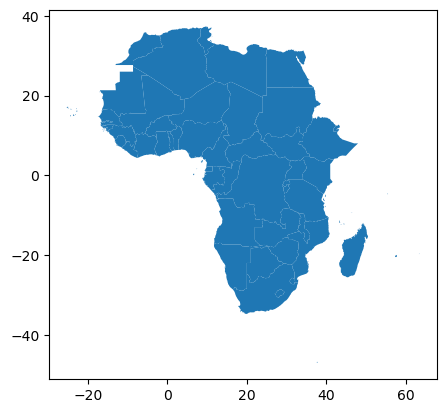

In [40]:
Africa=theMapAndData[theMapAndData.region=='AFRICA']
Africa.plot()

**What variable to use?** Let's go with population (countable).

A DDM can serve as an effective way to show the distribution of people. The most critical tasks are:

* Unit per Dot: Deciding how many people each dot should represent is key for visual clarity. This value should be chosen carefully to avoid oversaturation or sparsity.

* Dot Placement: The dots should be randomly distributed within each polygon to avoid misrepresenting the data.

Every dot represents the same amount, then a DDM uses raw counts (non-normalized). The size of all dots on the map are the same, which  ensures a consistent visual comparison.

### Preprocessing: NEW UNIT

How many people will the dot represent? There is some **trial and error** to make this decision, but it helps exploring the variable descriptives.

In [41]:
print(Africa.population.describe().to_string(float_format=lambda x: f'{x:.0f}'))

count          52
mean     28193457
std      41102292
min         98187
25%       2733577
50%      14341616
75%      33660488
max     236747130


From what we see, we should not choose 100 000 as the unit per dot. At least one country will have zero dots. Then, the trial and error is about choosing values like 1000, 10000, 20000, etc., but below 98187.

If we chose 25000, this would be the amount of points within each polygon (country):

In [42]:
(Africa.set_index("Country").population / 25000).astype(int).sort_values()

Country
SEYCHELLES                             3
SAO TOME AND PRINCIPE                  8
CAPE VERDE                            24
COMOROS                               36
DJIBOUTI                              39
ESWATINI                              45
MAURITIUS                             52
EQUATORIAL GUINEA                     71
GUINEA-BISSAU                         85
LESOTHO                               89
GABON                                 98
BOTSWANA                              98
GAMBIA                               100
NAMIBIA                              112
MAURITANIA                           173
LIBERIA                              217
CENTRAL AFRICAN REPUBLIC             226
CONGO                                243
LIBYA                                294
TOGO                                 356
SIERRA LEONE                         364
TUNISIA                              481
SOUTH SUDAN                          508
BURUNDI                              543
RWANDA  

This is a safe option (no zeroes).

### Preprocessing: NEW LAYER

We need to create a map of dots, a new layer. The source will be the Africa polygons we currently have. Let's do that first:

In [43]:
# a copy of Africa
temporal_gdf=Africa.copy()
temporal_gdf.head()

,Country,iso2,iso3,region,fragility,co2,sq_km,num_airports,population,mobiles,geometry
2,ALGERIA,DZ,DZA,AFRICA,75.4,151633000,2381740,95,47022473,51500000,"MULTIPOLYGON (((-5.15213 30.18047, -5.13917 30..."
6,ANGOLA,AO,AGO,AFRICA,87.8,19362000,1246700,107,37202061,25700000,"MULTIPOLYGON (((13.09139 -4.63306, 13.09264 -4..."
12,BOTSWANA,BW,BWA,AFRICA,59.5,5965000,581730,122,2450668,4440000,"MULTIPOLYGON (((26.40114 -24.63189, 26.38996 -..."
19,BENIN,BJ,BEN,AFRICA,73.6,6903000,112622,10,14697052,16400000,"MULTIPOLYGON (((2.73295 7.65821, 2.73222 7.651..."
26,BURUNDI,BI,BDI,AFRICA,98.2,715000,27830,6,13590102,8650000,"MULTIPOLYGON (((30.84366 -2.97879, 30.83723 -2..."


the GeoDF **temporal_gdf** is just an independent copy of Africa, as you see all the geometries are MULTIPOLYGONS still. Let me replace the row names by the country name:

In [44]:
# the row names will be the country
temporal_gdf.set_index('Country',inplace=True)

# we have this now
temporal_gdf.head()

,iso2,iso3,region,fragility,co2,sq_km,num_airports,population,mobiles,geometry
Country,,,,,,,,,,
ALGERIA,DZ,DZA,AFRICA,75.4,151633000,2381740,95,47022473,51500000,"MULTIPOLYGON (((-5.15213 30.18047, -5.13917 30..."
ANGOLA,AO,AGO,AFRICA,87.8,19362000,1246700,107,37202061,25700000,"MULTIPOLYGON (((13.09139 -4.63306, 13.09264 -4..."
BOTSWANA,BW,BWA,AFRICA,59.5,5965000,581730,122,2450668,4440000,"MULTIPOLYGON (((26.40114 -24.63189, 26.38996 -..."
BENIN,BJ,BEN,AFRICA,73.6,6903000,112622,10,14697052,16400000,"MULTIPOLYGON (((2.73295 7.65821, 2.73222 7.651..."
BURUNDI,BI,BDI,AFRICA,98.2,715000,27830,6,13590102,8650000,"MULTIPOLYGON (((30.84366 -2.97879, 30.83723 -2..."


Let's create **dots_per_country**, the column that represents the amount of dots for each country (like we saw before):

In [45]:
# creating  column 
temporal_gdf['dots_per_country'] = (Africa['population'] / 25000).astype(int).values # notice .values!

# see
temporal_gdf['dots_per_country'].head(10)

Country
ALGERIA                             1880
ANGOLA                              1488
BOTSWANA                              98
BENIN                                587
BURUNDI                              543
CHAD                                 763
CONGO                                243
DEMOCRATIC REPUBLIC OF THE CONGO    4616
CAMEROON                            1238
COMOROS                               36
Name: dots_per_country, dtype: int64

Let's find a **random_location** for the dots:

In [46]:
# enter 'sample_points()'
temporal_gdf.sample_points(size=temporal_gdf['dots_per_country'],rng=123).head(10)

Country
ALGERIA                             MULTIPOINT (-8.64514 27.70401, -8.59924 27.897...
ANGOLA                              MULTIPOINT (12.0628 -16.71525, 12.10423 -15.18...
BOTSWANA                            MULTIPOINT (20.26153 -24.22378, 20.36865 -24.2...
BENIN                               MULTIPOINT (0.81304 10.57673, 0.84972 10.65362...
BURUNDI                             MULTIPOINT (29.03506 -2.79301, 29.03678 -2.780...
CHAD                                MULTIPOINT (13.5274 14.43927, 13.61895 14.0839...
CONGO                               MULTIPOINT (11.34861 -3.61575, 11.41961 -3.759...
DEMOCRATIC REPUBLIC OF THE CONGO    MULTIPOINT (12.4375 -5.8711, 12.44332 -5.79615...
CAMEROON                            MULTIPOINT (8.54056 4.62486, 8.61714 4.81688, ...
COMOROS                             MULTIPOINT (43.22178 -11.76054, 43.25128 -11.6...
Name: sampled_points, dtype: geometry

That was a critical step, you created a...

In [47]:
type(temporal_gdf.sample_points(size=temporal_gdf['dots_per_country'],rng=123))

geopandas.geoseries.GeoSeries

Take a look at one of this series' element:

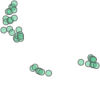

In [48]:
# this is the case of Comoros:
temporal_gdf.sample_points(size=temporal_gdf['dots_per_country'],rng=123).loc['COMOROS']

As usual, that GeoS is turned into a GeoDF:

In [49]:
Africa_dots=gpd.GeoDataFrame(geometry=temporal_gdf.sample_points(size=temporal_gdf['dots_per_country'],rng=123))
Africa_dots.head(10)

,geometry
Country,
ALGERIA,"MULTIPOINT (-8.64514 27.70401, -8.59924 27.897..."
ANGOLA,"MULTIPOINT (12.0628 -16.71525, 12.10423 -15.18..."
BOTSWANA,"MULTIPOINT (20.26153 -24.22378, 20.36865 -24.2..."
BENIN,"MULTIPOINT (0.81304 10.57673, 0.84972 10.65362..."
BURUNDI,"MULTIPOINT (29.03506 -2.79301, 29.03678 -2.780..."
CHAD,"MULTIPOINT (13.5274 14.43927, 13.61895 14.0839..."
CONGO,"MULTIPOINT (11.34861 -3.61575, 11.41961 -3.759..."
DEMOCRATIC REPUBLIC OF THE CONGO,"MULTIPOINT (12.4375 -5.8711, 12.44332 -5.79615..."
CAMEROON,"MULTIPOINT (8.54056 4.62486, 8.61714 4.81688, ..."


Now you have a GDF:

In [50]:
Africa_dots.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 52 entries, ALGERIA to SOUTH SUDAN
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  52 non-null     geometry
dtypes: geometry(1)
memory usage: 2.9+ KB


Here is our DDM:

<Axes: >

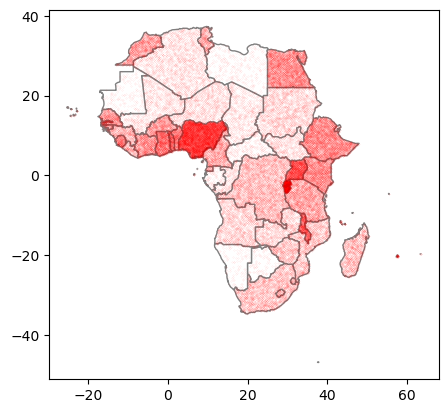

In [51]:
base=Africa.plot(facecolor="white",#color of polygon fill
               edgecolor='grey') #color of border
Africa_dots.plot(markersize=0.02, color='red',ax=base, alpha=0.2)

It is generally recommended that DDMs use an **equal-area projection**, which benefits density and limits area distortion.

In [52]:
Africa_8857=Africa.to_crs(8857)
Africa_dots_8857=Africa_dots.to_crs(8857)

<Axes: >

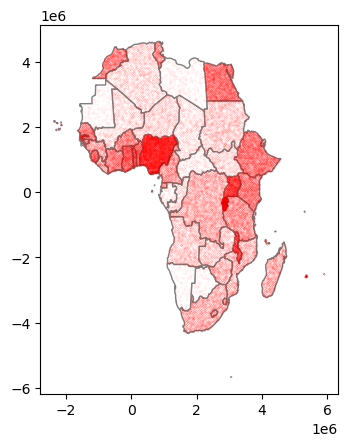

In [53]:
# new version
base=Africa_8857.plot(facecolor="white",
                              edgecolor='grey')
Africa_dots_8857.plot(markersize=0.02, color='red',ax=base, alpha=0.2)

### Exporting to R?

Africa_dots_8857 has a column of multi-points as we know. Shapefiles can not deal with this structure not visual programs in R such as **leaflet**. Then, we need to split those multipoints using **explode()**:

In [54]:
Africa_dots_8857.explode()

,geometry
Country,
ALGERIA,POINT (-782809.218 3488777.019)
ALGERIA,POINT (-778027.472 3512073.46)
ALGERIA,POINT (-779432.711 3451352.477)
ALGERIA,POINT (-771626.784 3559137.523)
ALGERIA,POINT (-771462.039 3553365.068)
...,...
SOUTH SUDAN,POINT (3391531.359 659742.661)
SOUTH SUDAN,POINT (3411569.233 603593.798)
SOUTH SUDAN,POINT (3410938.404 648228.346)


We may just need to get rid of the indexes:

In [55]:
Africa_dots_8857.explode(ignore_index=True)

,geometry
0,POINT (-782809.218 3488777.019)
1,POINT (-778027.472 3512073.46)
2,POINT (-779432.711 3451352.477)
3,POINT (-771626.784 3559137.523)
4,POINT (-771462.039 3553365.068)
...,...
58610,POINT (3391531.359 659742.661)
58611,POINT (3411569.233 603593.798)
58612,POINT (3410938.404 648228.346)
58613,POINT (3411422.201 658166.544)


The function **explodes()** returns...

In [56]:
type(Africa_dots_8857.explode(ignore_index=True))

geopandas.geodataframe.GeoDataFrame

This is a safe option outside Python:

In [57]:
# then
Africa_dots_8857=Africa_dots_8857.explode(ignore_index=True)

# Thematics: the PSM (Proportional Symbol Map)

You have a PSM if you use a symbol (generally a circle) to show the distribution of a variable per location.
The symbol is an aggregated raw value, and its size varies according to those values. So now we need:

### Preprocessing: scale the variable to determine size

How to adjust the size of a symbols based of population? We should not have symbol size five million!

In [58]:
##what about square root scaling
import numpy as np

max_size=40
min_size=1
scaled_sizes = np.sqrt(
    (Africa_8857.population - Africa_8857.population.min()) / (Africa_8857.population.max() - Africa_8857.population.min())
) * (max_size-1) + min_size

scaled_sizes.sort_values()

133     1.000000
149     1.897669
42      2.815506
36      3.270320
45      3.400805
165     3.585286
102     3.791389
50      4.303209
126     4.615784
92      4.699448
12      4.888440
59      4.892105
58      4.948033
163     5.169980
103     6.214047
91      6.857938
40      6.974027
31      7.209678
94      7.832390
148     8.529079
137     8.615256
150     9.764119
169    10.001043
26     10.312132
131    10.323582
66     10.447830
19     10.686611
168    11.468925
135    11.977545
29     12.049348
167    12.534725
98     12.800296
100    12.862035
158    13.143587
111    13.987701
95     14.735671
77     14.858894
35     15.085296
110    15.619288
61     15.888969
6      16.442654
101    16.481214
2      18.366454
154    18.779847
141    18.992619
82     20.332162
134    20.693868
153    21.807794
48     27.727924
32     28.223007
53     28.592035
112    40.000000
Name: population, dtype: float64

### Preprocessing: create new layer

Similar to DDM, the PSM is a new layer, built from the original polygons:

In [59]:
Africa_8857_symbols = Africa_8857.copy()
Africa_8857_symbols.set_index('Country',inplace=True)

#this is just a copy (new index names)
Africa_8857_symbols.head()

,iso2,iso3,region,fragility,co2,sq_km,num_airports,population,mobiles,geometry
Country,,,,,,,,,,
ALGERIA,DZ,DZA,AFRICA,75.4,151633000,2381740,95,47022473,51500000,"MULTIPOLYGON (((-461528.863 3785845.186, -4603..."
ANGOLA,AO,AGO,AFRICA,87.8,19362000,1246700,107,37202061,25700000,"MULTIPOLYGON (((1252211.409 -594965.255, 12523..."
BOTSWANA,BW,BWA,AFRICA,59.5,5965000,581730,122,2450668,4440000,"MULTIPOLYGON (((2419408.33 -3115326.798, 24184..."
BENIN,BJ,BEN,AFRICA,73.6,6903000,112622,10,14697052,16400000,"MULTIPOLYGON (((260709.591 982516.929, 260641...."
BURUNDI,BI,BDI,AFRICA,98.2,715000,27830,6,13590102,8650000,"MULTIPOLYGON (((2952925.496 -382651.512, 29522..."


Let's set the **size** of the symbol:

In [60]:
Africa_8857_symbols['size']=scaled_sizes.values # notice .values!

### Preprocessing: location for the symbol

We need one symbol per polygon, an obvious choice is the centroid.

In [61]:
# Africa_8857_locations will have a new geometry:
Africa_8857_symbols['geometry'] = Africa_8857_symbols['geometry'].centroid

# see the geom is NOW a POINT
Africa_8857_symbols

,iso2,iso3,region,fragility,co2,sq_km,num_airports,population,mobiles,geometry,size
Country,,,,,,,,,,,
ALGERIA,DZ,DZA,AFRICA,75.4,151633000,2381740,95,47022473,51500000,POINT (238502.141 3518510.55),18.366454
ANGOLA,AO,AGO,AFRICA,87.8,19362000,1246700,107,37202061,25700000,POINT (1660973.947 -1567698.855),16.442654
BOTSWANA,BW,BWA,AFRICA,59.5,5965000,581730,122,2450668,4440000,POINT (2201221.267 -2809166.362),4.888440
BENIN,BJ,BEN,AFRICA,73.6,6903000,112622,10,14697052,16400000,POINT (222846.461 1235558.191),10.686611
BURUNDI,BI,BDI,AFRICA,98.2,715000,27830,6,13590102,8650000,POINT (2860810.304 -431061.403),10.312132
CHAD,TD,TCD,AFRICA,108.5,1771000,1284000,44,19093595,12100000,POINT (1755417.429 1950748.319),12.049348
CONGO,CG,COG,AFRICA,92.5,4523000,342000,56,6097665,5870000,POINT (1457936.98 -107754.095),7.209678
DEMOCRATIC REPUBLIC OF THE CONGO,CD,COD,AFRICA,110.2,2653000,2344858,273,115403027,49800000,POINT (2261167.581 -366628.064),28.223007
CAMEROON,CM,CMR,AFRICA,97.0,7105000,475440,37,30966105,26200000,POINT (1217073.791 728109.574),15.085296


We got the basics, then:

<Axes: >

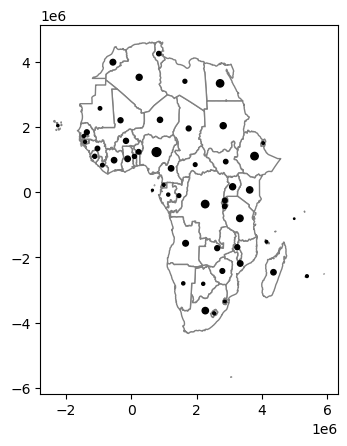

In [62]:
base=Africa_8857.plot(facecolor="white",
                      edgecolor='grey')
# Plot the centroids on top
Africa_8857_symbols.plot(
    ax=base,
    markersize=Africa_8857_symbols['size'],
    color='black'
)

Keep in mind that the standard way of computing centroids may bring some trouble if you have multipolygons (archipelagos?). Let´s plot Seychelles:

In [63]:
base=Africa_8857[Africa_8857.Country=="SEYCHELLES"].explore()
Africa_8857_symbols[Africa_8857_symbols.index=="SEYCHELLES"].explore(m=base,color="red")

The location is nowhere within a polygon. An  alternative is **representative_point()**:

In [64]:
# replace the points
Africa_8857_symbols["geometry"]=Africa_8857.representative_point().values

We will keep that last result.

In [65]:
base=Africa_8857[Africa_8857.Country=="SEYCHELLES"].explore()
Africa_8857_symbols[Africa_8857_symbols.index=="SEYCHELLES"].explore(m=base,color="red")

### Preprocessing: detect outliers

PPMs are not thematic maps to see precise values, but to reveal clear differences on the variable distribution used. As human eyes are very limited to detect area differences, we may need to use some other tactics to confirm if we have outliers:

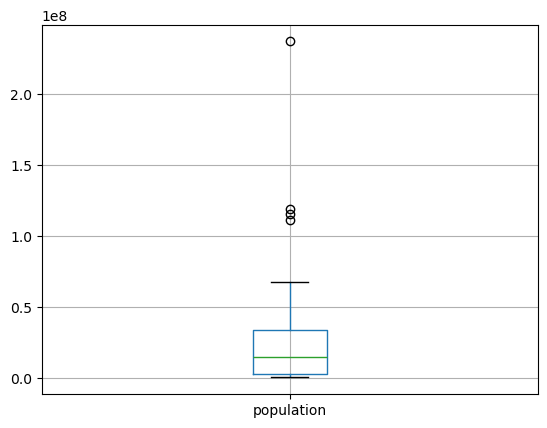

In [66]:
boxplotInfo=Africa_8857_symbols.boxplot(column='population',return_type="dict")

The object **boxplotInfo** showed the boxplot, and we confirm there are outliers. We can recover them like this:

In [67]:
outliers=boxplotInfo['fliers'][0].get_ydata()
## see
outliers

array([115403027, 111247248, 118550298, 236747130], dtype=object)

Then, these are the outlying countries:

In [68]:
Africa_8857_symbols[Africa_8857_symbols.population.isin(outliers)].index

Index(['DEMOCRATIC REPUBLIC OF THE CONGO', 'EGYPT', 'ETHIOPIA', 'NIGERIA'], dtype='object', name='Country')

Knowing this information, we can create a column as outlier flag:

In [69]:
Africa_8857_symbols['population_outlier']=Africa_8857_symbols.population.isin(outliers)*1

## see
Africa_8857_symbols

,iso2,iso3,region,fragility,co2,sq_km,num_airports,population,mobiles,geometry,size,population_outlier
Country,,,,,,,,,,,,
ALGERIA,DZ,DZA,AFRICA,75.4,151633000,2381740,95,47022473,51500000,POINT (58149.408 3504624.452),18.366454,0
ANGOLA,AO,AGO,AFRICA,87.8,19362000,1246700,107,37202061,25700000,POINT (1789934.856 -1524650.389),16.442654,0
BOTSWANA,BW,BWA,AFRICA,59.5,5965000,581730,122,2450668,4440000,POINT (2262432.346 -2828174.988),4.888440,0
BENIN,BJ,BEN,AFRICA,73.6,6903000,112622,10,14697052,16400000,POINT (219186.939 1191134.38),10.686611,0
BURUNDI,BI,BDI,AFRICA,98.2,715000,27830,6,13590102,8650000,POINT (2865100.606 -433659.14),10.312132,0
CHAD,TD,TCD,AFRICA,108.5,1771000,1284000,44,19093595,12100000,POINT (1747642.958 1965809.757),12.049348,0
CONGO,CG,COG,AFRICA,92.5,4523000,342000,56,6097665,5870000,POINT (1540711.045 -82846.788),7.209678,0
DEMOCRATIC REPUBLIC OF THE CONGO,CD,COD,AFRICA,110.2,2653000,2344858,273,115403027,49800000,POINT (2150454.367 -516111.79),28.223007,1
CAMEROON,CM,CMR,AFRICA,97.0,7105000,475440,37,30966105,26200000,POINT (1299556.828 944934.755),15.085296,0


We can use that like this:

<Axes: >

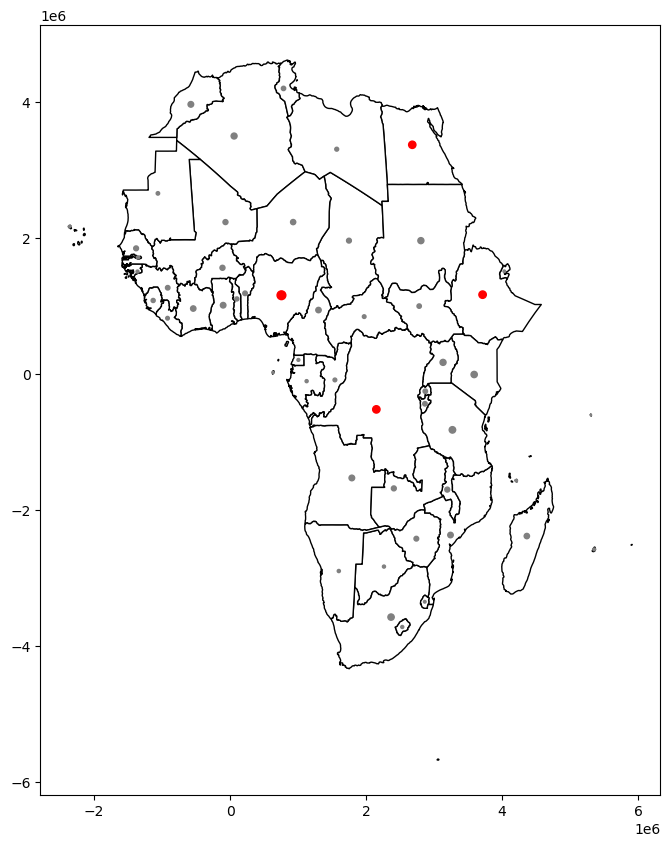

In [70]:
base = Africa_8857.plot(color='white', edgecolor='black', figsize=(10,10))

# Define your color map
mapcolor = {1: 'red', 0: 'grey'}

# Plot the centroids on top
Africa_8857_symbols.plot(
    ax=base,
    markersize=Africa_8857_symbols['size'],
    color=Africa_8857_symbols['population_outlier'].map(mapcolor)
)

## Exporting to R?

It is **almost** ready. R will use the new layer and the location of the points. However, R's ggplot needs NOT your size variable. Give GGPLOT the _population_ variables and use **scale_size_area()** to manage the size and the legend.

Also, notice that I have the country names as index, and the other columns might be redundant (they are in **Africa_8857**):

In [71]:
Africa_8857_symbols.head()

,iso2,iso3,region,fragility,co2,sq_km,num_airports,population,mobiles,geometry,size,population_outlier
Country,,,,,,,,,,,,
ALGERIA,DZ,DZA,AFRICA,75.4,151633000,2381740,95,47022473,51500000,POINT (58149.408 3504624.452),18.366454,0
ANGOLA,AO,AGO,AFRICA,87.8,19362000,1246700,107,37202061,25700000,POINT (1789934.856 -1524650.389),16.442654,0
BOTSWANA,BW,BWA,AFRICA,59.5,5965000,581730,122,2450668,4440000,POINT (2262432.346 -2828174.988),4.888440,0
BENIN,BJ,BEN,AFRICA,73.6,6903000,112622,10,14697052,16400000,POINT (219186.939 1191134.38),10.686611,0
BURUNDI,BI,BDI,AFRICA,98.2,715000,27830,6,13590102,8650000,POINT (2865100.606 -433659.14),10.312132,0


In [72]:
## then
Africa_8857_symbols.reset_index(drop=False, inplace=True)
Africa_8857_symbols.drop(columns=['iso2', 'region', 'fragility', 'co2', 'sq_km', 'num_airports','mobiles'], inplace=True)

## final for R:
Africa_8857_symbols.head()

,Country,iso3,population,geometry,size,population_outlier
0,ALGERIA,DZA,47022473,POINT (58149.408 3504624.452),18.366454,0
1,ANGOLA,AGO,37202061,POINT (1789934.856 -1524650.389),16.442654,0
2,BOTSWANA,BWA,2450668,POINT (2262432.346 -2828174.988),4.888440,0
3,BENIN,BEN,14697052,POINT (219186.939 1191134.38),10.686611,0
4,BURUNDI,BDI,13590102,POINT (2865100.606 -433659.14),10.312132,0


Done!

# Thematics: Choropleths

Notice that we do not normalized DDMs nor PSMs: data is just a count or a representation of counts. Choropleths will 'paint' the whole polygon and as noticed in PSMs, we have to be very careful when using color in shape, as the area itself is a confounding. To control this visual artifact, the variable must be normalized, that is, divided by a value correlated with the area.

Then, for this course, a choropleth is a normalized representation of data.

Following our definition:

* This is **NOT** a choropleth:


<Axes: >

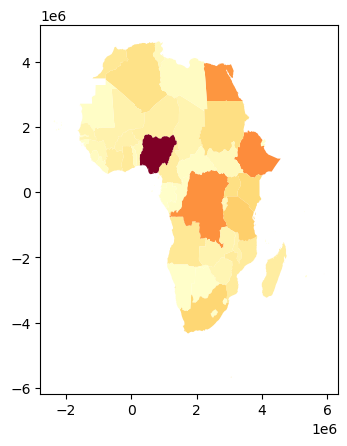

In [73]:
Africa_8857.plot(Africa_8857.population,cmap="YlOrRd")

### Preprocessing: Normalization

* This **IS** a choropleth:

<Axes: >

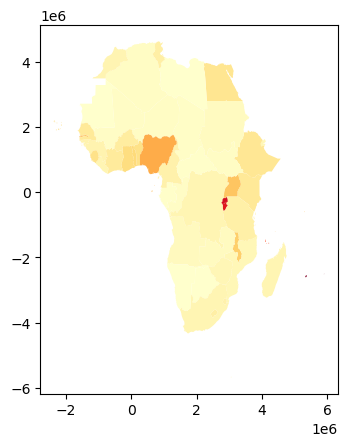

In [74]:
Africa_8857.plot(Africa_8857.population/Africa_8857.sq_km,cmap="YlOrRd")

Choropleths are great to represent normalized indicators such as:
* Densities
* Proportion
* Ratios
* Averages

This is a density:

In [75]:
Africa_8857['population_density']=Africa_8857.population/Africa_8857.sq_km

### Preprocessing: Discretizing

Population by area is a density indicator. This is a real number (not an integer), so most of the time the color gradient might  not be that useful to reveal some pattern visually. Then, we often discretize (or bin) the indicator computed.
Now, we want to cut the variable. Run the next code to make sure you have tose packages:

In [76]:
## do you have these installed?
# pip show numba mapclassify numpy

Let's explore the bining algorithms:

In [77]:
import mapclassify
import numpy as np

np.random.seed(12345) # so we all get the same results!

# let's try 5 intervals
K=5
theVar=Africa_8857['population_density']

# same interval width, easy interpretation
ei5 = mapclassify.EqualInterval(theVar, k=K)
# same interval width based on standard deviation, easy - but not as the previous one, poor when high skewness
msd = mapclassify.StdMean(theVar)
# interval width varies, counts per interval are close, not easy to grasp, repeated values complicate cuts
q5=mapclassify.Quantiles(theVar,k=K)

# based on similarity, good for multimodal data
mb5 = mapclassify.MaximumBreaks(theVar, k=K)
# based on similarity, good for skewed data
ht = mapclassify.HeadTailBreaks(theVar) # no K needed
# based on similarity, optimizer
fj5 = mapclassify.FisherJenks(theVar, k=K)
# based on similarity, optimizer
jc5 = mapclassify.JenksCaspall(theVar, k=K)
# based on similarity, optimizer
mp5 = mapclassify.MaxP(theVar, k=K)

How can we select the right classification?
Let me use the the Absolute deviation around class median (ADCM) to make the comparisson:

In [78]:
class5 = ei5,msd, q5,mb5,  ht, fj5, jc5, mp5
# Collect ADCM for each classifier
fits = np.array([ c.adcm for c in class5])
# Convert ADCM scores to a DataFrame
adcms = pd.DataFrame(fits)
# Add classifier names
adcms['classifier'] = [c.name for c in class5]
# Add column names to the ADCM
adcms.columns = ['ADCM', 'Classifier']

Now, plot the **adcms**:

<Axes: ylabel='Classifier'>

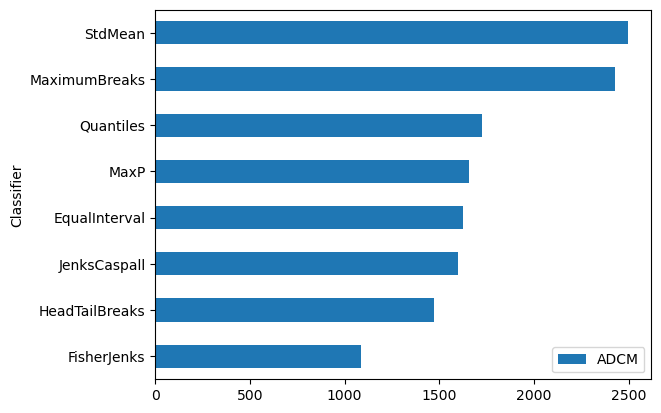

In [79]:
adcms.sort_values('ADCM').plot.barh(x='Classifier')

Let's save the best strategy:

In [80]:
Africa_8857['population_density_FJ5'] = fj5.yb # yb will give you a numeric label

In [81]:
# there you are
Africa_8857[['population_density','population_density_FJ5']].head(20)

,population_density,population_density_FJ5
2,19.742908,0
6,29.840428,0
12,4.212724,0
19,130.498943,1
26,488.325620,3
29,14.870401,0
31,17.829430,0
32,49.215358,0
35,65.131468,0
36,402.747651,3


We could create a copy of that column to add descriptive labels:

In [82]:
# renaming
newLabelsForLevels={0:"0_VeryLow", 1:"1_Low", 2:"2_Middle", 3:"3_High", 4:"4_VeryHigh"}

Africa_8857['population_density_FJ5_cat']=Africa_8857.loc[:,'population_density_FJ5'].replace(newLabelsForLevels)

# we have
Africa_8857[['population_density','population_density_FJ5','population_density_FJ5_cat']].head(20)

,population_density,population_density_FJ5,population_density_FJ5_cat
2,19.742908,0,0_VeryLow
6,29.840428,0,0_VeryLow
12,4.212724,0,0_VeryLow
19,130.498943,1,1_Low
26,488.325620,3,3_High
29,14.870401,0,0_VeryLow
31,17.829430,0,0_VeryLow
32,49.215358,0,0_VeryLow
35,65.131468,0,0_VeryLow
36,402.747651,3,3_High


We are ready for a discrete choropleth:

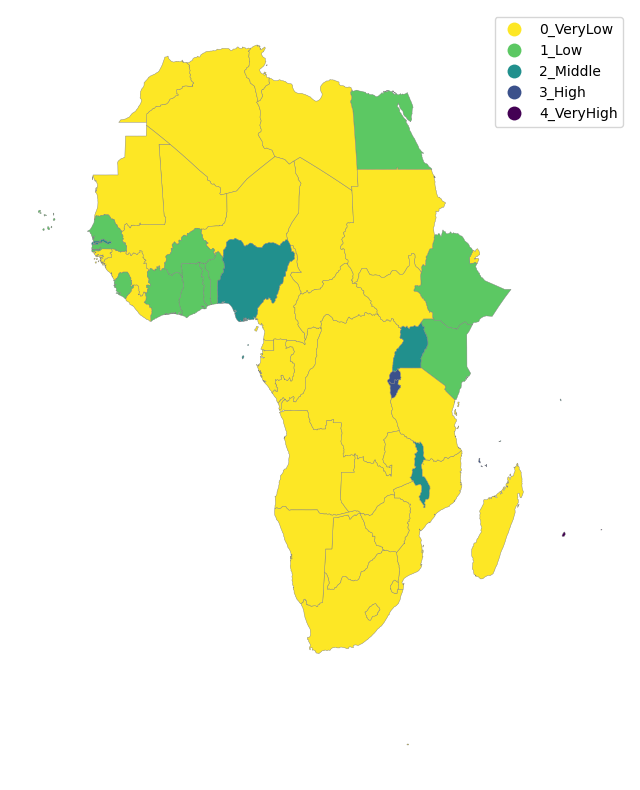

In [83]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, figsize=(10, 10))
Africa_8857.plot(column='population_density_FJ5_cat', # variable to plot
                 cmap='viridis_r', # set of colors
                 categorical=True, # can be interpreted as category
                 edgecolor='grey', # border color
                 linewidth=0.3, # width of border
                 legend=True, # need a legend?
                 ax=ax
       )

ax.set_axis_off()

# Saving

Let's save these maps for R.

In [84]:
## Good practice to refresh your memory

## Find only GeoDataFrames in the current session
geodataframe_list = [var for var in globals() if isinstance(globals()[var], gpd.GeoDataFrame)]

print("List of GeoDataFrames in memory:")
for name in geodataframe_list:
    print(name)

List of GeoDataFrames in memory:
countries
_14
_22
_23
theMapAndData
_38
Africa
_43
temporal_gdf
_44
_49
Africa_dots
Africa_8857
Africa_dots_8857
_54
_55
_59
Africa_8857_symbols
_61
_69
_71
_72


These are the ones needed in R:

In [85]:
# for choropleth and base map
Africa_8857.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 52 entries, 2 to 169
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   Country                     52 non-null     object  
 1   iso2                        51 non-null     object  
 2   iso3                        52 non-null     object  
 3   region                      52 non-null     object  
 4   fragility                   52 non-null     float64 
 5   co2                         52 non-null     int64   
 6   sq_km                       52 non-null     int32   
 7   num_airports                52 non-null     int32   
 8   population                  52 non-null     int32   
 9   mobiles                     52 non-null     int32   
 10  geometry                    52 non-null     geometry
 11  population_density          52 non-null     float64 
 12  population_density_FJ5      52 non-null     int64   
 13  population_density

In [86]:
# for DDMs
Africa_dots_8857.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 58615 entries, 0 to 58614
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  58615 non-null  geometry
dtypes: geometry(1)
memory usage: 458.1 KB


In [87]:
# for PSMs
Africa_8857_symbols.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Country             52 non-null     object  
 1   iso3                52 non-null     object  
 2   population          52 non-null     int32   
 3   geometry            52 non-null     geometry
 4   size                52 non-null     float64 
 5   population_outlier  52 non-null     int64   
dtypes: float64(1), geometry(1), int32(1), int64(1), object(2)
memory usage: 2.4+ KB


The file **africa_8857.gpkg** will keep all those maps as layers!

In [88]:
Africa_8857.to_file("africa_8857.gpkg",driver='GPKG',layer='continent')
Africa_dots_8857.to_file("africa_8857.gpkg",driver='GPKG',layer='population_ddm')
Africa_8857_symbols.to_file("africa_8857.gpkg",driver='GPKG',layer='population_psm')

Take a look at the [Dashboard](https://dacss-spatial.github.io/The-Thematics/draft_storyboard_tabs.html)